In [1]:
# Import Pandas, Numpy, Matplotlib, and Sqlite3
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import sqlite3
from seaborn import plt
from matplotlib.dates import date2num, num2date
import re
import json
import urllib
from datetime import datetime

# This enables inline Plots
%matplotlib inline

In [2]:
data_file = 'Medtrack_Deals-MA-Private_21Jan2015.csv'
#Add new column names, initial col names had spaces and slashes
df_cols = ['date', 'category', 'acquirer', 'target', 'value', 'headline']
df = pd.read_csv(data_file, sep=',', names = df_cols)
#Remove initial col names, anything w/o date or value
df = df[1:].dropna(subset=['date', 'value'])
#Replace commas in value and parse number
df['value'] = [float(v.replace(',','')) for v in df.value]
#Check only for values > 100M
df = df[df.value >= 100]
l = map(lambda x: x.split('/'),df.date)
year = map(lambda x: int(x[2]), l)
df['year'] = year
df.reset_index(drop=True, inplace=True)
df.head()

,date,category,acquirer,target,value,headline,year
0,1/16/2015,Majority Acquisition,"Roche Holding, Ltd.",Trophos SA,550.7,Roche to acquire Trophos,2015
1,1/13/2015,Exit,"Otsuka Pharmaceutical Co., Ltd.","AVANIR Pharmaceuticals, Inc.",1495.2,"Baker Brother, T. Rowe Price, and Fidelity Man...",2015
2,1/12/2015,Majority Acquisition,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,Roche Holding to acquire majority stake in Fou...,2015
3,1/11/2015,Majority Acquisition,"Biogen Idec, Inc.","Convergence Pharmaceuticals, Ltd.",675.0,Biogen Idec to acquire Convergence Pharmaceuti...,2015
4,1/7/2015,Majority Acquisition,BTG plc,"PneumRx, Inc.",475.0,BTG acquires PneumRx,2015


In [91]:
#df['acquirer'].str.contains(r"\(formerly|\|")
df[7:11]

,date,category,acquirer,target,value,headline,year,a_symbol,a_start,a_end
7,1/1/2015,Majority Acquisition,"Elanco India Pvt., Ltd.|Eli Lilly and Company","Novartis Animal Health, Inc.",5400.0,Eli Lilly and Company acquires Novartis Animal...,2015,,,
8,12/18/2014,Majority Acquisition,"Merck &amp; Co., Inc. (formerly Schering-Ploug...",OncoEthix SA,375.0,Merck acquires OncoEthix,2014,,,
9,12/18/2014,Majority Acquisition,"Roche Holding, Ltd.",Dutalys GmbH,488.8,Roche to acquire Dutalys,2014,,,
10,12/17/2014,Majority Acquisition,Astorg Partners|Montagu Private Equity LLP,SEBIA SA,1747.0,Astorg Partners and Montagu Private Equity acq...,2014,,,


In [3]:
#function to search yahoo for symbol based on comp name, parse to json, then pull first symbol entry
def name_to_symbol(cname):
    cname = re.sub('[^A-Za-z0-9]+', ' ', cname)
    name.split('(formerly')[0] #use the first name if includes 'formerly company x'
    s_name = urllib.quote(cname)
    url = 'http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={name}&callback=YAHOO.Finance.SymbolSuggest.ssCallback'.format(name = s_name)
    string = urllib.urlopen(url).read()
    string = string.replace('YAHOO.Finance.SymbolSuggest.ssCallback(','')
    string = string[:-1]
    data = json.loads(string)
    result = data['ResultSet']['Result']
    if len(result) == 0:
        symbol = ''
    else:
        symbol = result[0]['symbol']
    return symbol

In [ ]:
#Add column with stock symbols where available
symbol = []
for name in df.acquirer:
    symbol.append(name_to_symbol(name))
df['a_symbol'] = symbol
df.head()

In [133]:
def get_historical_prices(symbol, date):
    """
    Get historical prices for the given ticker symbol.
    First will need to split date on '/'
    
    Returns a json list.
    """
    #Stocks from current date
    m2 = datetime.datetime.today().month - 1
    d2 = datetime.datetime.today().day
    y2 = datetime.datetime.today().year
    
    #Go back to five years before deal
    m, d, y = date.split('/')
    m = str(int(m) - 1)
    d1 = d
    m1 = m
    y1 = str(int(y) - 5)
    
    url = 'http://ichart.yahoo.com/table.csv?s=%s&' % symbol + \
          'd=%s&' % m2 + \
          'e=%s&' % d2 + \
          'f=%s&' % y2 + \
          'g=d&' + \
          'a=%s&' % m1 + \
          'b=%s&' % d1 + \
          'c=%s&' % y1 + \
          'ignore=.csv'
    days = urllib.urlopen(url).readlines()
#     return days
    data = [day[:-2].split(',') for day in days]
    data = pd.DataFrame(data = data[1:], columns = data[0])
    ndate=[] #numeric date
    for i in range(len(x)):
        ndate.append(datetime.datetime.strptime(data.Date[i],'%Y-%m-%d'))
    x['ndate'] = ndate
    return data

In [129]:
def GrabClose(x, d):
    #Pull Close value from stock dataframe
    #assumes d is date as dataframe object
    month, day, year = date.split('/')
    d = datetime.datetime(int(year), int(month), int(day))
    val = x[x.ndate == d]
    while len(x[x.ndate == d]) == 0 and (d <= x.ndate[0]):
        #If we don't have data for a date take the next date, as long as we're not past max date
        d = d + datetime.timedelta(days = 1)
        val = x[x.ndate == d]
    val.reset_index(inplace=True, drop=True)
    return float(val.ix[0].Close)

In [135]:
x = get_historical_prices('PFE', '1/1/2014')
x

,Date,Open,High,Low,Close,Volume,Adj Clos
0,2015-03-09,33.87,34.18,33.66,34.03,30166600,34.0
1,2015-03-06,34.25,34.46,33.75,33.97,39852400,33.9
2,2015-03-05,34.73,34.81,34.40,34.47,22600900,34.4
3,2015-03-04,34.49,34.77,34.26,34.64,19287900,34.6
4,2015-03-03,34.75,34.89,34.41,34.56,24045200,34.5
5,2015-03-02,34.32,34.80,34.06,34.77,21352000,34.7
6,2015-02-27,34.44,34.66,34.29,34.32,24388900,34.3
7,2015-02-26,34.47,34.72,34.38,34.59,19902800,34.5
8,2015-02-25,34.25,34.79,33.93,34.66,37220000,34.6
9,2015-02-24,34.22,34.34,34.08,34.34,19357500,34.3


In [76]:
import datetime
finaldate = datetime.datetime(2015,3,15)
finaldate - datetime.timedelta(days=365)

datetime.datetime(2014, 3, 15, 0, 0)

In [34]:
y, m, d = x['Date'][i].split('-')

In [86]:
val0 = []
val = []
for i in range(len(df)):
    if df.a_symbol[i] == '':
        start.append('')
        end.append('')
    else:
        data = get_historical_prices(df.a_symbol[i], df.date[i])
        if len(data[0]) == 1:
            start.append('')
            end.append('')
        else:
            start.append(float(data[-1][1]))
            end.append(float(data[1][1]))

In [87]:
df['a_start'] = start
df['a_end'] = end
df.head()

,date,category,acquirer,target,value,headline,year,a_symbol,a_start,a_end
0,1/16/2015,Majority Acquisition,"Roche Holding, Ltd.",Trophos SA,550.7,Roche to acquire Trophos,2015,,,
1,1/13/2015,Exit,"Otsuka Pharmaceutical Co., Ltd.","AVANIR Pharmaceuticals, Inc.",1495.2,"Baker Brother, T. Rowe Price, and Fidelity Man...",2015,,,
2,1/12/2015,Majority Acquisition,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,Roche Holding to acquire majority stake in Fou...,2015,,,
3,1/11/2015,Majority Acquisition,"Biogen Idec, Inc.","Convergence Pharmaceuticals, Ltd.",675.0,Biogen Idec to acquire Convergence Pharmaceuti...,2015,BIIB,299.35,349.78
4,1/7/2015,Majority Acquisition,BTG plc,"PneumRx, Inc.",475.0,BTG acquires PneumRx,2015,BTGGF,9.76,12.2


In [114]:
df[df.a_symbol != '']

UnicodeDecodeError: 'ascii' codec can't decode byte 0xef in position 6684: ordinal not in range(128)

In [88]:
x = (df.a_symbol != '')
x.sum()

650

In [53]:
df

,date,category,acquirer,target,value,headline,year,a_symbol,a_start,a_end
0,1/16/2015,Majority Acquisition,"Roche Holding, Ltd.",Trophos SA,550.7,Roche to acquire Trophos,2015,,,
1,1/13/2015,Exit,"Otsuka Pharmaceutical Co., Ltd.","AVANIR Pharmaceuticals, Inc.",1495.2,"Baker Brother, T. Rowe Price, and Fidelity Man...",2015,,,
2,1/12/2015,Majority Acquisition,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,Roche Holding to acquire majority stake in Fou...,2015,,,
3,1/11/2015,Majority Acquisition,"Biogen Idec, Inc.","Convergence Pharmaceuticals, Ltd.",675.0,Biogen Idec to acquire Convergence Pharmaceuti...,2015,BIIB,299.35,349.78
4,1/7/2015,Majority Acquisition,BTG plc,"PneumRx, Inc.",475.0,BTG acquires PneumRx,2015,BTGGF,9.76,12.2
5,1/6/2015,Majority Acquisition,Cardio3 BioSciences SA,"OnCyte, LLC",203.0,Cardio3 Biosciences acquires OnCyte from Celda...,2015,CARD.BR,25,36.1
6,1/2/2015,Asset Purchase,Virbac S.A,Eli Lilly and Company - US veterinary assets,410.0,Virbac acquires veterinary assets from Eli Lilly,2015,,,
7,1/1/2015,Majority Acquisition,"Elanco India Pvt., Ltd.|Eli Lilly and Company","Novartis Animal Health, Inc.",5400.0,Eli Lilly and Company acquires Novartis Animal...,2015,,,
8,12/18/2014,Majority Acquisition,"Merck &amp; Co., Inc. (formerly Schering-Ploug...",OncoEthix SA,375.0,Merck acquires OncoEthix,2014,,,
9,12/18/2014,Majority Acquisition,"Roche Holding, Ltd.",Dutalys GmbH,488.8,Roche to acquire Dutalys,2014,,,


In [92]:
#Count number of entries
#len(df[df.t_symbol != ''])
#df[df['target'].str.contains(r"\(formerly|\|")]

In [93]:
dif = []
for i in range(len(df)):
    if df.a_start[i] == '':
        dif.append('')
    else:
       dif.append(df.a_end[i] - df.a_start[i])
df['a_dif'] = dif
df.head()

,date,category,acquirer,target,value,headline,year,a_symbol,a_start,a_end,a_dif
0,1/16/2015,Majority Acquisition,"Roche Holding, Ltd.",Trophos SA,550.7,Roche to acquire Trophos,2015,,,,
1,1/13/2015,Exit,"Otsuka Pharmaceutical Co., Ltd.","AVANIR Pharmaceuticals, Inc.",1495.2,"Baker Brother, T. Rowe Price, and Fidelity Man...",2015,,,,
2,1/12/2015,Majority Acquisition,"Roche Holding, Ltd.","Foundation Medicine, Inc.",780.0,Roche Holding to acquire majority stake in Fou...,2015,,,,
3,1/11/2015,Majority Acquisition,"Biogen Idec, Inc.","Convergence Pharmaceuticals, Ltd.",675.0,Biogen Idec to acquire Convergence Pharmaceuti...,2015,BIIB,299.35,349.78,50.43
4,1/7/2015,Majority Acquisition,BTG plc,"PneumRx, Inc.",475.0,BTG acquires PneumRx,2015,BTGGF,9.76,12.2,2.44


In [74]:
df_valid = df[df.t_dif != '']
tyeardif = df_valid[['year', 't_dif']].sort('year')

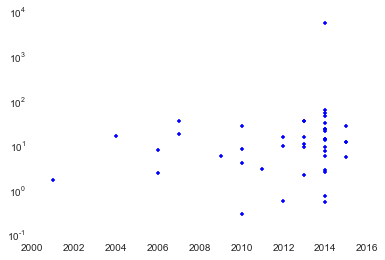

In [78]:
plt.plot(tyeardif.year, tyeardif.t_dif, 'b.')
plt.yscale('log')